In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from time import time
%matplotlib notebook

In [2]:
# Paths
image_path = 'source.tiff'
mask_path = 'mask.tiff'

# Load the image (grayscale) and the mask
img = np.asarray(Image.open(image_path).convert('L'))
mask = np.asarray(Image.open(mask_path))[:,:,0]

# plt.imshow(img, cmap="gray")
# plt.show()

# Normalize images to float in [0,1]; Change the name to fit the paper
I = img.astype(np.float32) / 255.
p = mask.astype(np.float32) / 255.

In [3]:
def box_filter2(img, r):

    height, width = img.shape

    # Vertical pass
    iiv = np.cumsum(img, axis=0)
    img2 = np.zeros(img.shape, dtype=np.float)
    img2[0:r+1, :] = iiv[r:2*r+1, :] / np.array(range(r, 2*r+1)).reshape((r+1,1))
    img2[r+1:height-r, :] = (iiv[2*r+1:height, :] - iiv[0:height-2*r-1, :]) / (2*r+1)
    img2[height-r:height,:] = (iiv[height-1,:] - iiv[height-2*r-1:height-r-1,:]) / np.array(range(2*r, r, -1)).reshape((r,1))

    # Horizontal pass
    iih = np.cumsum(img2, axis=1)
    img3 = np.zeros(img.shape, dtype=np.float)
    img3[:, 0:r+1] = iih[:, r:2*r+1] / np.array(range(r, 2*r+1)).reshape((1, r+1))
    img3[:, r+1:width-r] = (iih[:, 2*r+1:width] - iih[:, 0:width-2*r-1]) / (2*r+1)
    img3[:, width-r:width] = (np.expand_dims(iih[:,width-1], axis=1) - iih[:,width-2*r-1:width-r-1]) / np.array(range(2*r, r, -1)).reshape((1,r))

    return img3

In [4]:
def guided_filter_v3(I, p, radius, eps):

    # Compute I * p
    Ip = np.multiply(I, p)
    I2 = I**2

    # Compute some values
    I_mean = box_filter2(I, radius)
    p_mean = box_filter2(p, radius)
    Ip_mean = box_filter2(Ip, radius)
    I2_mean = box_filter2(I2, radius)
    I_var = I2_mean - I_mean**2

    # Compute a and b
    a = (Ip_mean - np.multiply(I_mean, p_mean)) / (I_var + eps)
    b = p_mean - np.multiply(a, I_mean)

    # Deduce a_mean and b_mean
    a_mean = box_filter2(a, radius)
    b_mean = box_filter2(b, radius)

    # Finally get the output mask
    q = np.multiply(a_mean, I) + b_mean

    # Clip values in [0,1]
    q = np.clip(q, 0, 1)

    return q

Elapsed time V1 :  0.042 s


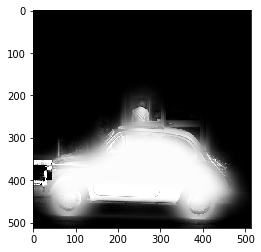

In [5]:
# Test the guided filter
radius = 23
eps = 0.0001

tic = time()
q = guided_filter_v3(I, p, radius, eps)
toc = time()
print('Elapsed time V1 : %6.3f s' % (toc-tic))

plt.figure()
plt.imshow(q, cmap="gray")
plt.show()

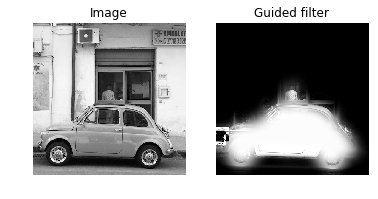

aW50ZXJhY3RpdmUoY2hpbGRyZW49KENoZWNrYm94KHZhbHVlPUZhbHNlLCBkZXNjcmlwdGlvbj11J2FwcGx5X2d1aWRlZF9maWx0ZXInKSwgSW50U2xpZGVyKHZhbHVlPTEwLCBkZXNjcmlwdGnigKY=


In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

f, ax = plt.subplots(1,2)
img_ax0 = ax[0].imshow(I, vmin=0., vmax=1., cmap='gray')
img_ax1 = ax[1].imshow(q, vmin=0., vmax=1., cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title('Image')
ax[1].set_title('Guided filter')
plt.show()

def update(apply_guided_filter, radius, power):
    eps = pow(10,power)
    print('radius = %d' % radius)
    print('eps    = %.7f' % eps)
    if apply_guided_filter:
        q = guided_filter_v3(I, p, radius, eps)
        img_ax1.set_array(q)
    else:
        img_ax1.set_array(p)
    f.canvas.draw()
    
interact(update, apply_guided_filter=False, radius=widgets.IntSlider(min=1,max=30,step=1,value=10), power=widgets.IntSlider(min=-7,max=0,step=1,value=-3));
